In [23]:
import numpy as np
import matplotlib.pyplot as plt 
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

## Variational quantum eigensolver

Variational quantum eigensolver (VQE) [[1]](#Peruzzo2016) es un algoritmo que sirve para encontrar una cota superior para la mínima energía de un Hamiltoniano $\hat{H}$ (operador autoadjunto), es decir, el menor autovalor de $\hat{H}$. VQE es una herramienta útil en la búsqueda de una aproximación al estado basal, esto es, el autoestado asociado a la mínima energía. Para ello, VQE resuelve el problema

\begin{equation}
 \min_{|\psi\rangle}\frac{
 \langle\psi|\hat{H}|\psi\rangle}{\langle\psi|\psi\rangle}
\end{equation}

lo que significa que se busca un estado $|\psi\rangle$ que minimice el coeficiente de Rayleigh. Magnitud que puede ser eficientemente evaluada mediante un computador cuántico, y minimizada en un computador clásico. Para llevar a cabo esta tarea, se necesita aprender tres cosas: 

1) Mapear el Hamiltoniano $\hat{H}$ a un computador cuántico.
2) Generar el estado $|\psi\rangle$ en un circuito cuántico paramétrico.
3) Evaluar el valor esperado del hamiltoniano $\hat{H}$.

## Primer Paso: Mapeo del Hamiltoneano

Hamiltonianos moleculares en segunda cuantización [[2]](#Tilly2022) pueden ser definidos como operadores termiónicos mediante la función PySCFDriver() de la librería qiskit_nature.second_q.drivers. Para guardar dicho Hamiltoniano se hace uso de la función json.dump() de la librería json. Adicionalmente, mediante la función json.load() se puede cargar un Hamiltoniano previamente guardado.

In [24]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver

driver = PySCFDriver(
            atom = "H 0 0 0; H 0 0 0.735",
            basis="sto3g",
            charge=0,
            spin=0,
            unit=DistanceUnit.ANGSTROM,
            )


problem = driver.run()
hamiltonian  = problem.hamiltonian
fermionic_op = hamiltonian.second_q_op()
print(fermionic_op)

Fermionic Operator
number spin orbitals=4, number terms=36
  0.33785507740175813 * ( +_0 +_0 -_0 -_0 )
+ 0.09046559989211565 * ( +_0 +_0 -_1 -_1 )
+ 0.09046559989211556 * ( +_0 +_1 -_0 -_1 )
+ 0.33229086512764827 * ( +_0 +_1 -_1 -_0 )
+ 0.33785507740175813 * ( +_0 +_2 -_2 -_0 )
+ 0.09046559989211565 * ( +_0 +_2 -_3 -_1 )
+ 0.09046559989211556 * ( +_0 +_3 -_2 -_1 )
+ 0.33229086512764827 * ( +_0 +_3 -_3 -_0 )
+ 0.33229086512764816 * ( +_1 +_0 -_0 -_1 )
+ 0.09046559989211574 * ( +_1 +_0 -_1 -_0 )
+ 0.09046559989211564 * ( +_1 +_1 -_0 -_0 )
+ 0.34928686136600906 * ( +_1 +_1 -_1 -_1 )
+ 0.33229086512764816 * ( +_1 +_2 -_2 -_1 )
+ 0.09046559989211574 * ( +_1 +_2 -_3 -_0 )
+ 0.09046559989211564 * ( +_1 +_3 -_2 -_0 )
+ 0.34928686136600906 * ( +_1 +_3 -_3 -_1 )
+ 0.33785507740175813 * ( +_2 +_0 -_0 -_2 )
+ 0.09046559989211565 * ( +_2 +_0 -_1 -_3 )
+ 0.09046559989211556 * ( +_2 +_1 -_0 -_3 )
+ 0.33229086512764827 * ( +_2 +_1 -_1 -_2 )
+ 0.33785507740175813 * ( +_2 +_2 -_2 -_2 )
+ 0.0904655998921

In [25]:
# Guardar operador fermiónico

fermionic_op_dict = fermionic_op.__dict__

import json
with open("fermionic_op.json", "w") as outfile: 
    json.dump(fermionic_op_dict, outfile)

In [26]:
# Cargar operador Fermiónico

from qiskit_nature.second_q.operators.fermionic_op import FermionicOp
import json
infile = open('fermionic_op.json')
fermionic_op_dict = json.load(infile)
fermionic_op = FermionicOp( fermionic_op_dict['_data'] )
print( fermionic_op )

Fermionic Operator
number spin orbitals=4, number terms=36
  0.33785507740175813 * ( +_0 +_0 -_0 -_0 )
+ 0.09046559989211565 * ( +_0 +_0 -_1 -_1 )
+ 0.09046559989211556 * ( +_0 +_1 -_0 -_1 )
+ 0.33229086512764827 * ( +_0 +_1 -_1 -_0 )
+ 0.33785507740175813 * ( +_0 +_2 -_2 -_0 )
+ 0.09046559989211565 * ( +_0 +_2 -_3 -_1 )
+ 0.09046559989211556 * ( +_0 +_3 -_2 -_1 )
+ 0.33229086512764827 * ( +_0 +_3 -_3 -_0 )
+ 0.33229086512764816 * ( +_1 +_0 -_0 -_1 )
+ 0.09046559989211574 * ( +_1 +_0 -_1 -_0 )
+ 0.09046559989211564 * ( +_1 +_1 -_0 -_0 )
+ 0.34928686136600906 * ( +_1 +_1 -_1 -_1 )
+ 0.33229086512764816 * ( +_1 +_2 -_2 -_1 )
+ 0.09046559989211574 * ( +_1 +_2 -_3 -_0 )
+ 0.09046559989211564 * ( +_1 +_3 -_2 -_0 )
+ 0.34928686136600906 * ( +_1 +_3 -_3 -_1 )
+ 0.33785507740175813 * ( +_2 +_0 -_0 -_2 )
+ 0.09046559989211565 * ( +_2 +_0 -_1 -_3 )
+ 0.09046559989211556 * ( +_2 +_1 -_0 -_3 )
+ 0.33229086512764827 * ( +_2 +_1 -_1 -_2 )
+ 0.33785507740175813 * ( +_2 +_2 -_2 -_2 )
+ 0.0904655998921

Para simular sistemas fermiónicos en computadores cuánticos, los operadores fermiónicos deben ser codificados en redes de qubits. Para ello, comúnmente se utiliza la
transformación de Jordan-Wigner [[3]](#JW1928) (concretamente su transformación inversa) para convertir un Hamiltoniano fermiónico en un Hamiltoniano de spín. Esto se ejecuta en Qiskit mediante la función JordanWignerMapper() de la libreria qiskit_nature.second_q.mappers.

In [27]:
from qiskit_nature.second_q.mappers import JordanWignerMapper
mapper = JordanWignerMapper()
qubit_op = mapper.map(fermionic_op)
print( qubit_op )

-0.8105479805373279 * IIII
- 0.22575349222402363 * IIZI
+ 0.17218393261915543 * IIIZ
+ 0.12091263261776629 * IIZZ
+ 0.1721839326191555 * IZII
+ 0.16892753870087907 * IZIZ
+ 0.045232799946057826 * YYYY
+ 0.045232799946057826 * XXYY
+ 0.045232799946057826 * YYXX
+ 0.045232799946057826 * XXXX
- 0.2257534922240237 * ZIII
+ 0.1661454325638241 * ZIIZ
+ 0.1661454325638241 * IZZI
+ 0.17464343068300453 * ZIZI
+ 0.12091263261776629 * ZZII


## Segundo Paso: Generar el ansatz

Nos referimos por ansatz a un circuito cuántico paramétrico que determina los estados cuánticos $|\psi({\theta})\rangle = U({\theta})|0\rangle$ considerados en la minimización de la energía. Los estados ansatz están caracterizados por secuencias de capas de compuertas paramétricas de un qubit como por ejemplo $Rx(\theta_1)R_y(\theta_2)$, las cuales se repiten un cierto número de veces, y entre cada repetición se encuentra una compuerta que entrelaza los qubits. 

![image.png](Ansatz.png)

Para crear este circuito paramétrico (hardware eficiente [[2]](#Tilly2022)), debemos utilizar la función ParameterVector() de qiskit. Esta, crea un conjunto de variables simbólicas que son utilizadas como argumento en las puertas del ansatz.

Instrucción: Escribir un código que genere el ansatz requerido, para un número de qubits y de capas indicadas (Para el ejemplo se utiliza 4 y 2 respectivamente).

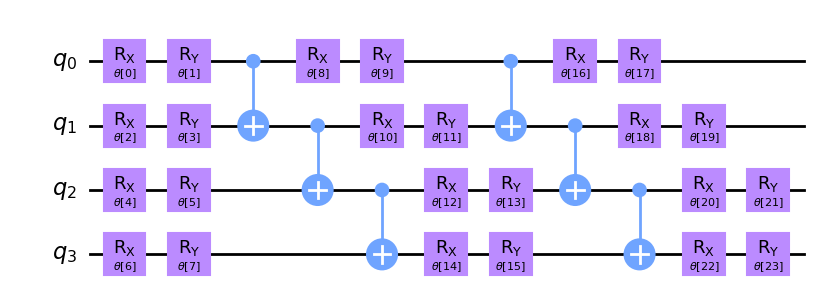

In [28]:
nqubits = fermionic_op.num_spin_orbitals
reps    = 2

# Ansatz generation

theta   = ParameterVector( '$\\theta$', 2*nqubits*(reps+1) )
ansatz = QuantumCircuit(nqubits)

for r in range(reps+1):
    for q in range(nqubits):
        ansatz.rx( theta[ 2*r*nqubits + 2*q ] , q )
        ansatz.ry( theta[ 2*r*nqubits + 2*q + 1 ] , q )
    if r < reps:
        for k in range(nqubits-1):
            ansatz.cx( k, k+1  )

ansatz.draw('mpl')


## Tercer Paso: Evaluar el valor de expectacion y minimizar la energía

Para estimar valores esperados de circuitos cuánticos y observables, se utiliza la función Estimator() de la librería qiskit_aer.primitives. Luego, se puede minimizar la energía mediante cualquier optimizador clásico, por ejemplo la función SPSA() de la librería qiskit.algorithms.optimizers.

Instrucción: Estudie la documentación de <a href="https://docs.quantum.ibm.com/api/qiskit/qiskit.primitives.Estimator#run">qiskit.algorithms.optimizers</a> de Qiskit, para ejecutar el método .run() de la función Estimator(). Esto es, completar los tres inputs faltantes en  

    estimator.run( , , , shots=100 ) 

en los siguientes fragmentos de código. Luego, revise la documentación de <a href="https://docs.quantum.ibm.com/api/qiskit/qiskit.algorithms.optimizers.Optimizer">qiskit.algorithms.optimizers</a> de Qiskit, para realizar la minimización de la función objetivo. Esto es, completar los inputs de 
    optimizer.minimize( , )
    
Observación: Observe el output de optimizer.minimize( , ) y vea como obtener el valor mínimo y los parámetros que determinan el estado de mínima energía.

In [29]:
from qiskit_aer.primitives import Estimator

estimator = Estimator()
theta = np.zeros(ansatz.num_parameters)

job = estimator.run( ansatz, qubit_op, theta, shots=100 )

values = job.result().values
print(values) 

[-0.00904656]


In [30]:
from qiskit.algorithms.optimizers import SPSA 

data_per_iter = []
callback      = lambda evals_num, params, fun_value, stepsize, step_accepted : data_per_iter.append( fun_value )
    
maxiter   = 200 
optimizer = SPSA( maxiter=maxiter, callback=callback ) 

obj_func = lambda theta : estimator.run( ansatz, 
                                        qubit_op, 
                                        theta,
                                        shots=100 ).result().values

initial_params = np.random.randn(ansatz.num_parameters)

results = optimizer.minimize( obj_func, initial_params )
print(results)


{   'fun': array([-1.84629372]),
    'jac': None,
    'nfev': 600,
    'nit': 200,
    'njev': None,
    'x': array([ 0.50412423,  1.4047183 , -0.21053601, -0.17908357,  0.15825144,
       -1.47232246,  1.15153055, -1.24928564,  1.50991238,  1.1286514 ,
       -1.2081615 , -1.47528115,  0.38594461, -0.12071539,  0.94286126,
       -0.50465445,  1.32849842,  2.1596434 ,  0.11268372,  0.04026971,
        1.7747313 , -1.15308513, -2.09683668,  0.39419071])}


In [31]:
data_per_iter

[array([-1.00104703]),
 array([-0.94839585]),
 array([-0.82511948]),
 array([-0.75612107]),
 array([-0.84161883]),
 array([-0.8422032]),
 array([-0.86951723]),
 array([-0.97643965]),
 array([-1.16778768]),
 array([-1.10942827]),
 array([-1.2745586]),
 array([-1.14566679]),
 array([-1.19760677]),
 array([-1.09369283]),
 array([-1.19693201]),
 array([-1.33715495]),
 array([-1.19905604]),
 array([-1.23698247]),
 array([-1.34600115]),
 array([-1.36100478]),
 array([-1.29513334]),
 array([-1.27459136]),
 array([-1.33133429]),
 array([-1.39665194]),
 array([-1.30771914]),
 array([-1.41198474]),
 array([-1.48236559]),
 array([-1.30063268]),
 array([-1.43524253]),
 array([-1.43547287]),
 array([-1.47475057]),
 array([-1.49495645]),
 array([-1.54619097]),
 array([-1.62453152]),
 array([-1.64267894]),
 array([-1.66853748]),
 array([-1.58881622]),
 array([-1.59541996]),
 array([-1.5530743]),
 array([-1.58098409]),
 array([-1.51538256]),
 array([-1.49341541]),
 array([-1.56115158]),
 array([-1.548

## Analisis de resultados

Para determinar la performance (convergencia y velocidad de convergencia) del optimizador en la minimización de la energía, se necesita un valor mínimo de referencia. Para este ejemplo pedagógico, podemos hacer "trampa" y calcular dicho mínimo clásicamente al diagonalizar el Hamiltoniano $\hat{H}$.


In [32]:
from qiskit.algorithms.eigensolvers import NumPyEigensolver
classical_solver  = NumPyEigensolver()
results_classical = classical_solver.compute_eigenvalues( qubit_op )
min_of_energy     = results_classical.eigenvalues
print(min_of_energy)

[-1.85727503]


Text(0, 0.5, 'Energía')

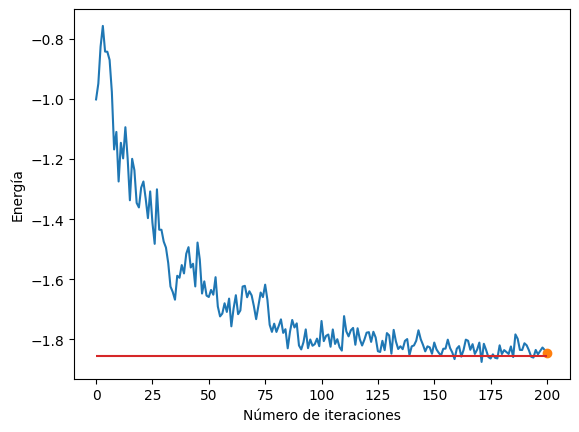

In [33]:
plt.plot( data_per_iter )
plt.plot( [maxiter], [results.fun], 'o' )
plt.hlines( min_of_energy, 0, maxiter, color='tab:red' )
plt.xlabel('Número de iteraciones')
plt.ylabel('Energía')

## Implementación de VQE

Para realizar una implementación de VQE solo resta juntar los tres pasos anteriores.

Instrucciones: Escribir una función que entregue una estimación del mínimo de la energía y los parámetros $\theta$ que determinan el estado que la minimiza. Para ello debe entregarse al programa el número de layers que considera el ansatz y el número de iteraciones del optimizador clásico (SPSA en este caso). Luego cargue el Hamiltoniano generado previamente y llame a la función VQE. Finalmente, realice un gráfico que muestre la estimación de la energía mínima entregada por VQE en cada iteración.


In [44]:
from qiskit.algorithms.optimizers import QNSPSA
from qiskit.primitives import Sampler

def VQE(nqubits, qubit_op, reps, maxiter):
    
    # Paso 2: Definir el Ansatz

    theta   = ParameterVector( '$\\theta$', 2*nqubits*(reps+1) )
    ansatz = QuantumCircuit(nqubits)

    for r in range(reps+1):
        for q in range(nqubits):
            ansatz.rx( theta[ 2*r*nqubits + 2*q ] , q )
            ansatz.ry( theta[ 2*r*nqubits + 2*q + 1 ] , q )
        if r < reps:
            for k in range(nqubits-1):
                ansatz.cx( k, k+1  )   
    
    # Paso 3:
    
    data_per_iter = []
    callback = lambda evals_num, params, fun_value, stepsize, step_accepted : data_per_iter.append( fun_value )
    
    optimizer = SPSA( maxiter=maxiter, callback=callback )
       
    #fidelity = QNSPSA.get_fidelity(ansatz, Sampler())
    #optimizer = QNSPSA( fidelity=fidelity, maxiter=maxiter, callback=callback )
    
    obj_func = lambda theta : estimator.run( ansatz, 
                                            qubit_op,  
                                            theta, 
                                            shots=100 ).result().values

    initial_params = np.random.randn(ansatz.num_parameters)
    results= optimizer.minimize( obj_func, initial_params )
    
    return results.fun, results.x, data_per_iter


Text(0, 0.5, 'Energía')

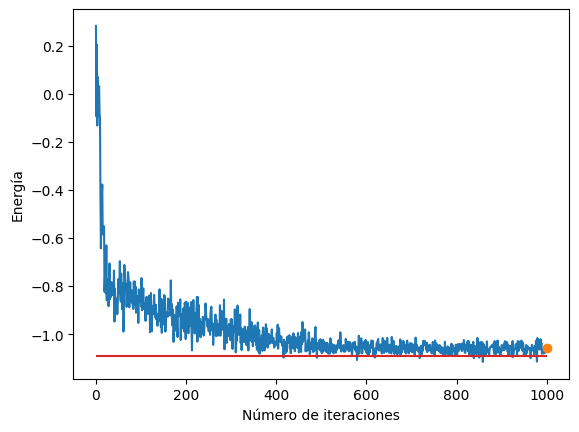

In [54]:
# Cargar librerias en caso de no haberlo hecho antes

# from qiskit_nature.second_q.operators.fermionic_op import FermionicOp
# import json

## Paso 1: Definir Hamiltoniano
infile = open('fermionic_op2.json')
fermionic_op_dict = json.load(infile)
fermionic_op = FermionicOp( fermionic_op_dict['_data'] )
mapper = JordanWignerMapper()

qubit_op = mapper.map(fermionic_op)

## Implementacion (LLamar a función VQE)
nqubits = fermionic_op.num_spin_orbitals
reps = 0
maxiter = 1000

estimated_energy, estimated_theta, data_per_iter = VQE(nqubits, qubit_op, reps, maxiter)

##  Analisis de resultados

# Obtener valor de referencia
classical_solver  = NumPyEigensolver()
results_classical = classical_solver.compute_eigenvalues( qubit_op )
min_of_energy     = results_classical.eigenvalues

# Plotear resultados
plt.plot( data_per_iter )
plt.plot( [maxiter], [estimated_energy], 'o' )
plt.hlines( min_of_energy, 0, maxiter, color='tab:red' )
plt.xlabel('Número de iteraciones')
plt.ylabel('Energía')


In [52]:
from qiskit.quantum_info import Statevector
State = Statevector(ansatz.assign_parameters(estimated_theta))
print(State)

Traceback (most recent call last):
  Cell In[52], line 2
    State = Statevector(ansatz.assign_parameters(estimated_theta))
  File /opt/conda/lib/python3.10/site-packages/qiskit/circuit/quantumcircuit.py:2771 in assign_parameters
    raise ValueError(
ValueError: Mismatching number of values and parameters. For partial binding please pass a dictionary of {parameter: value} pairs.

Use %tb to get the full traceback.


In [42]:
State.data @ State.data.conj()

(1+0j)

## Tarea 1: 

Comparar el funcionamiento de la función VQE al considerar distintos números de layers.

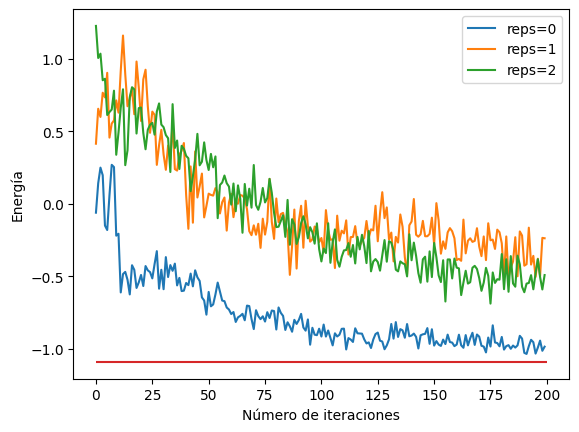

In [53]:
results_per_rep = []

for k in range(3):
    np.random.seed(10)
    estimated_energy, estimated_theta, data_per_iter = VQE(nqubits, qubit_op, k, maxiter)
    plt.plot( data_per_iter, label='reps={}'.format(k) )

plt.hlines( min_of_energy, 0, maxiter, color='tab:red' )
plt.xlabel('Número de iteraciones')
plt.ylabel('Energía')
plt.legend()

## Tarea 2:

Cambiar el optimizador clásico utilizado en la función VQE (SPSA). Para ello revise la documentación de Qiskit respecto a <a href="https://docs.quantum.ibm.com/api/qiskit/qiskit.algorithms.optimizers">optimizadores</a>. Por ejemplo, para utilizar el optimizador QN-SPSA se debe cargar las funciones 

    from qiskit.algorithms.optimizers import QNSPSA
    from qiskit.primitives import Sampler

 y remplazar el optimizador utilizado, mediante el siguiente segmento de código:
      
    fidelity = QNSPSA.get_fidelity( ansatz, Sampler() )
    optimizer = QNSPSA( fidelity=fidelity, maxiter=maxiter, callback=callback )

Observacion: Para este ejemplo, el optimizador QN-SPSA funciona peor que SPSA, requiriendo cerca de 1000 iteraciones para converger.   

## Tarea 3:

Ejecutar la implementación de VQE para simular la partícula de LiH. Para ello, utilice el operador fermiónico guardado en la variable fermionic_op2.json. Además, determine el número de layers adecuado a considerar en el ansatz y el optimizador más favorable para alcanzar una buena estimación del mínimo de la energía.


## Referencias

<a id='Peruzzo2016'>[1]</a> Peruzzo, A., McClean, J., Shadbolt, P. et al. A variational eigenvalue solver on a photonic quantum processor. *Nat Commun 5*, 4213 (2014). https://doi.org/10.1038/ncomms5213

<a id='Tilly2022'>[2]</a> Jules Tilly, Hongxiang Chen, Shuxiang Cao, Dario Picozzi, Kanav Setia, Ying Li, Edward Grant, Leonard Wossnig, Ivan Rungger, George H. Booth, Jonathan Tennyson,
The Variational Quantum Eigensolver: A review of methods and best practices,
*Physics Reports*,
Volume 986,
2022,
Pages 1-128,
ISSN 0370-1573,
https://doi.org/10.1016/j.physrep.2022.08.003.

<a id='JW1928'>[3]</a> Jordan, P., Wigner, E. Über das Paulische Äquivalenzverbot. Z. *Physik* 47, 631–651 (1928). https://doi.org/10.1007/BF01331938

## Contactos: 

Mario Muñoz <br> 
Doctor en Ciencias Aplicadas Mencion en Ingeniería Matemática <br> 
Universidad de Concepción <br>
munozmunozmarioalejandro@gmail.com

Luciano Pereira <br>
Predoctoral researcher, IFF-CSIC, Spain <br>
luciano.pereira.valenzuela@gmail.com 

In [27]:
import qiskit.tools.jupyter
%qiskit_version_table